# Test de torch vision sur la dataset : FashionMnist


In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Création du Dataset

In [ ]:
traindata = datasets.FashionMNIST(root = "data",
                                  train=True,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)
testdata = datasets.FashionMNIST(root = "data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)


100%|██████████| 26421880/26421880 [00:02<00:00, 10473900.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177843.21it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:11<00:00, 377188.57it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21592276.99it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(traindata)
len(testdata)

10000

In [ ]:
classnames = traindata.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = traindata.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
image, label = traindata[0]

dimension de l'image : torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

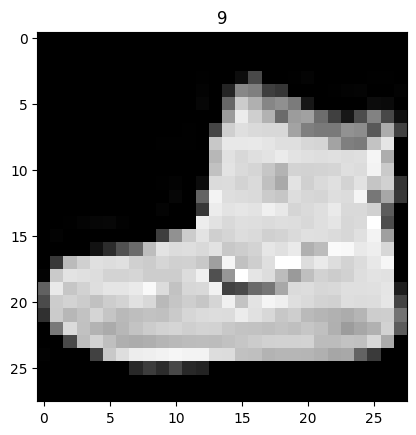

In [ ]:
print(f"dimension de l'image : {image.shape}")
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(label)

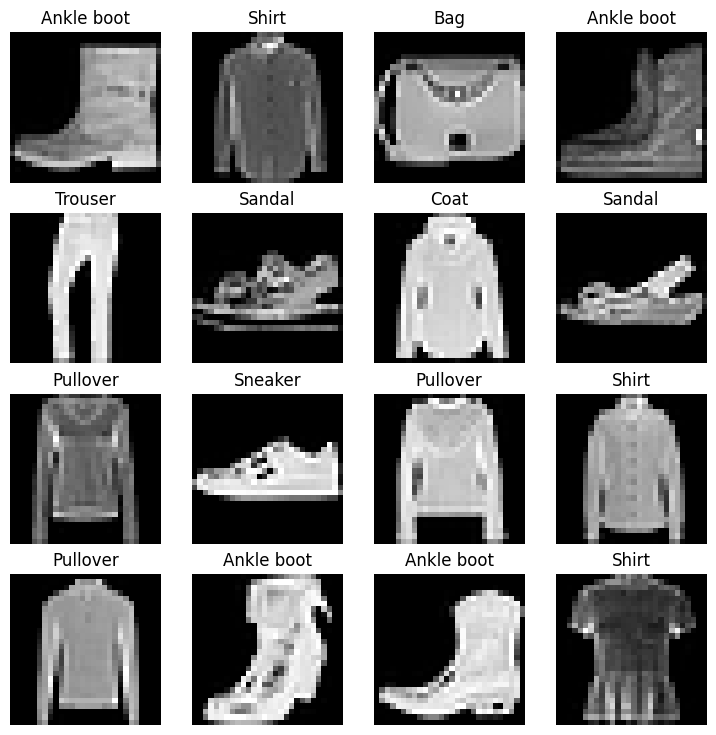

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4,4
for i in range (1, rows*cols +1):
  random_id = torch.randint(0,len(traindata), size = [1]).item()
  fig.add_subplot(rows,cols, i)
  image, label = traindata[random_id]
  plt.title(classnames[label])
  plt.imshow(image.squeeze(), cmap = "gray")
  plt.axis(False)


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(testdata, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_features, label_features = next(iter(train_dataloader))


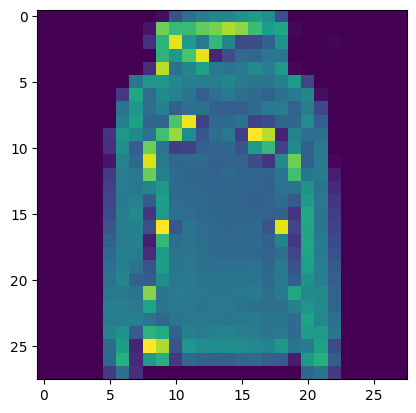

In [ ]:
plt.imshow(train_features[5].squeeze())

In [ ]:
import torch.optim as optim

In [ ]:
class fashionmnist_model0(nn.Module):
  def __init__(self):
    super().__init__()
    input = 28*28
    hidden = 128
    output = 10
    self.flatten = nn.Flatten()
    self.linear_layers = nn.Sequential(
        nn.Linear(in_features=input, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features = hidden, out_features = output)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_layers(x)
    return x



In [ ]:
model0 = fashionmnist_model0()
x_logit = model0(train_features)
x_logit[0]

tensor([ 0.1192,  0.0644,  0.0399,  0.0783,  0.0376,  0.0132,  0.0273,  0.0273,
        -0.0086, -0.0218], grad_fn=<SelectBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model0.parameters(), lr= 0.1)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


# Training loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
next(model0.parameters()).device

device(type='cpu')

In [ ]:
model0.train()
model0.to(device)

fashionmnist_model0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
"""
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch : {epoch}")
  train_loss = 0
  model0.to(device)
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model0.train()

    y_pred = model0(X)

    loss = loss_fn(y_pred, y)
    train_loss +=loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f" Avancement : {batch * len(X)} / {len(train_dataloader.dataset)} samples. ")

  train_loss /= len(train_dataloader)

  #Testing
  test_loss, test_acc = 0,0
  model0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  print(f"\n Train loss : {train_loss:.3f} | test loss : {test_loss:.3f} | Test acc : {test_acc:.3f}")



"""

'\nepochs = 3\nfor epoch in tqdm(range(epochs)):\n  print(f"epoch : {epoch}")\n  train_loss = 0\n  model0.to(device)\n  for batch, (X, y) in enumerate(train_dataloader):\n    X, y = X.to(device), y.to(device)\n    model0.train()\n\n    y_pred = model0(X)\n\n    loss = loss_fn(y_pred, y)\n    train_loss +=loss\n\n    optimizer.zero_grad()\n\n    loss.backward()\n\n    optimizer.step()\n\n    if batch % 400 == 0:\n      print(f" Avancement : {batch * len(X)} / {len(train_dataloader.dataset)} samples. ")\n\n  train_loss /= len(train_dataloader)\n\n  #Testing\n  test_loss, test_acc = 0,0\n  model0.eval()\n  with torch.inference_mode():\n    for X_test, y_test in test_dataloader:\n      X_test, y_test = X_test.to(device), y_test.to(device)\n      test_pred = model0(X_test)\n\n      test_loss += loss_fn(test_pred, y_test)\n\n      test_acc += accuracy_fn(y_true=y_test, y_pred = test_pred.argmax(dim = 1))\n\n    test_loss /= len(test_dataloader)\n\n    test_acc /= len(test_dataloader)\n\n  pr

In [ ]:
x_logit = model0(train_features.to(device))
(torch.argmax(x_logit, axis = 1)-label_features.to(device)) == 0

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False], device='cuda:0')

In [ ]:
def visual_test(model):
  model.to(device)
  fig = plt.figure(figsize = (12,12))
  rows, cols = 4,4
  for i in range (1, rows*cols +1):
    random_id = torch.randint(0,len(testdata), size = [1]).item()
    fig.add_subplot(rows,cols, i)
    image, label = testdata[random_id]
    image = image.to(device)
    #print(testdata[random_id])
    pred = classnames[torch.argmax(model(image))]
    plt.title(f"{classnames[label]}, pred : {pred}")
    plt.imshow(image.cpu().squeeze(), cmap = "gray")
    plt.axis(False)

In [ ]:
def visual_test_cnn(model):
  model.to(device)
  fig = plt.figure(figsize = (12,12))
  rows, cols = 4,4
  for i in range (1, rows*cols +1):
    random_id = torch.randint(0,len(testdata), size = [1]).item()
    fig.add_subplot(rows,cols, i)
    image, label = testdata[random_id]
    image = image.unsqueeze(0).to(device)
    #print(testdata[random_id])
    pred = classnames[torch.argmax(model(image))]
    plt.title(f"{classnames[label]}, pred : {pred}")
    plt.imshow(image.cpu().squeeze(), cmap = "gray")
    plt.axis(False)

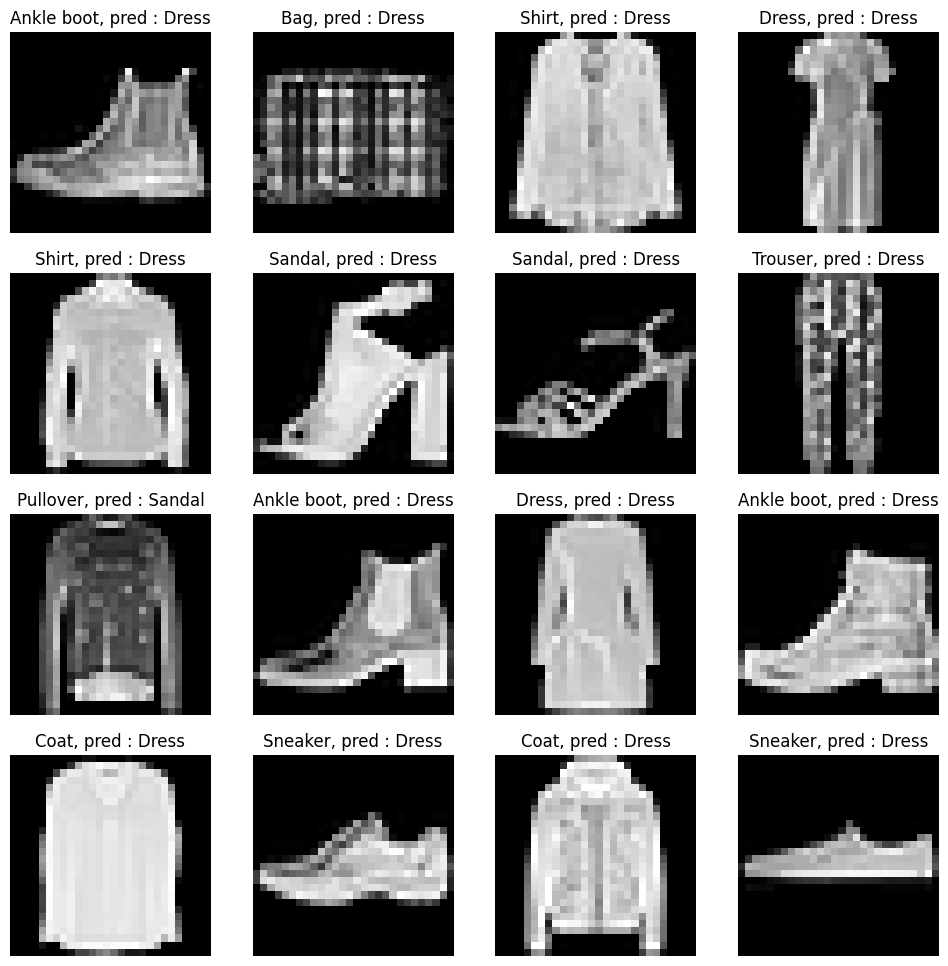

In [ ]:
visual_test(model0)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def evaluer_model(model, loss_fn_ev, device=device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0,0
    for X_test, y_test in test_dataloader:
      model.to(device)
      X_test = X_test.to(device)
      y_test = y_test.to(device)


      test_pred = model(X_test)

      test_loss += loss_fn_ev(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": test_loss.item(),
            "model_acc": test_acc}




In [ ]:
evaluer_model(model0, loss_fn)

{'model_name': 'fashionmnist_model0',
 'model_loss': 2.3076906204223633,
 'model_acc': 11.401757188498403}

In [ ]:
def train_step(model, loss_fn_train_step, optimizer_train_step, device=device):
  train_loss = 0
  model.to(device)
  for batch, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    model.train()
    y_pred = model(X)

    loss = loss_fn_train_step(y_pred, y)
    train_loss +=loss

    optimizer_train_step.zero_grad()

    loss.backward()

    optimizer_train_step.step()

    if batch % 400 == 0:
      print(f" Avancement : {batch * len(X)} / {len(train_dataloader.dataset)} samples. ")

  train_loss /= len(train_dataloader)
  print(f"Train loss de cette epoch {train_loss:.3f}")


In [ ]:
def test_step(model, loss_fn_test_step, optimizertest_step):
  test_loss, test_acc = 0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn_test_step(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  print(f"\nTest loss : {test_loss:.3f} | Test acc : {test_acc:.3f}")



In [ ]:
#train_step(model0, loss_fn, optimizer)

In [ ]:
test_step(model0, loss_fn, optimizer)


Test loss : 2.308 | Test acc : 11.402


# Training loop avec les fonctions normalisés

In [ ]:
epochs = 1

for epoch in tqdm(range(epochs)):
  #train_step(model0, loss_fn, optimizer)
  #test_step(model0, loss_fn, optimizer)
  print(f"epoch : {epoch}")


  0%|          | 0/1 [00:00<?, ?it/s]

epoch : 0


In [ ]:
evaluer_model(model0, loss_fn)

{'model_name': 'fashionmnist_model0',
 'model_loss': 2.3075287342071533,
 'model_acc': 11.421725239616613}

In [ ]:
class first_convulutionnal_nn(nn.Module):
  def __init__(self):
    super().__init__()

    self.input_units = 1
    self.hidden_units = 10
    self.output_units = 10

    self.conv_layers_1 = nn.Sequential(
        nn.Conv2d(
                  in_channels= self.input_units,
                  out_channels=self.hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels= self.hidden_units,
                  out_channels=self.hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1),

        nn.MaxPool2d(kernel_size=(2,2),
                  stride=2)
        )
    self.conv_layers_2 = nn.Sequential(
        nn.Conv2d(
            in_channels= self.hidden_units,
                  out_channels=self.hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),
                  stride=2)
        )
    self.classifiaction_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.hidden_units*7*7, out_features=self.output_units)
    )


  def forward(self, x):
    #print(x.shape)
    x = self.conv_layers_1(x)
    #print(x.shape)
    x = self.conv_layers_2(x)
    #print(x.shape)
    x = self.classifiaction_layers(x)
    return x



In [ ]:
model1 = first_convulutionnal_nn()
model1.to(device)

first_convulutionnal_nn(
  (conv_layers_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layers_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifiaction_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# Loss fn et optimizer

In [ ]:
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(params=model1.parameters(), lr = 0.1)

# Training convolutional network

In [ ]:
#training loop

epochs = 2
for epoch in range(epochs):
  train_step(model1, loss_fn_cnn, optimizer_cnn)
  test_step(model1, loss_fn_cnn, optimizer_cnn)


 Avancement : 0 / 60000 samples. 
 Avancement : 12800 / 60000 samples. 
 Avancement : 25600 / 60000 samples. 
 Avancement : 38400 / 60000 samples. 
 Avancement : 51200 / 60000 samples. 
Train loss de cette epoch 0.313

Test loss : 0.323 | Test acc : 88.179
 Avancement : 0 / 60000 samples. 
 Avancement : 12800 / 60000 samples. 
 Avancement : 25600 / 60000 samples. 
 Avancement : 38400 / 60000 samples. 
 Avancement : 51200 / 60000 samples. 
Train loss de cette epoch 0.295

Test loss : 0.330 | Test acc : 87.939


In [ ]:
evaluer_model(model1, loss_fn_cnn)

{'model_name': 'first_convulutionnal_nn',
 'model_loss': 0.330623984336853,
 'model_acc': 87.94928115015975}

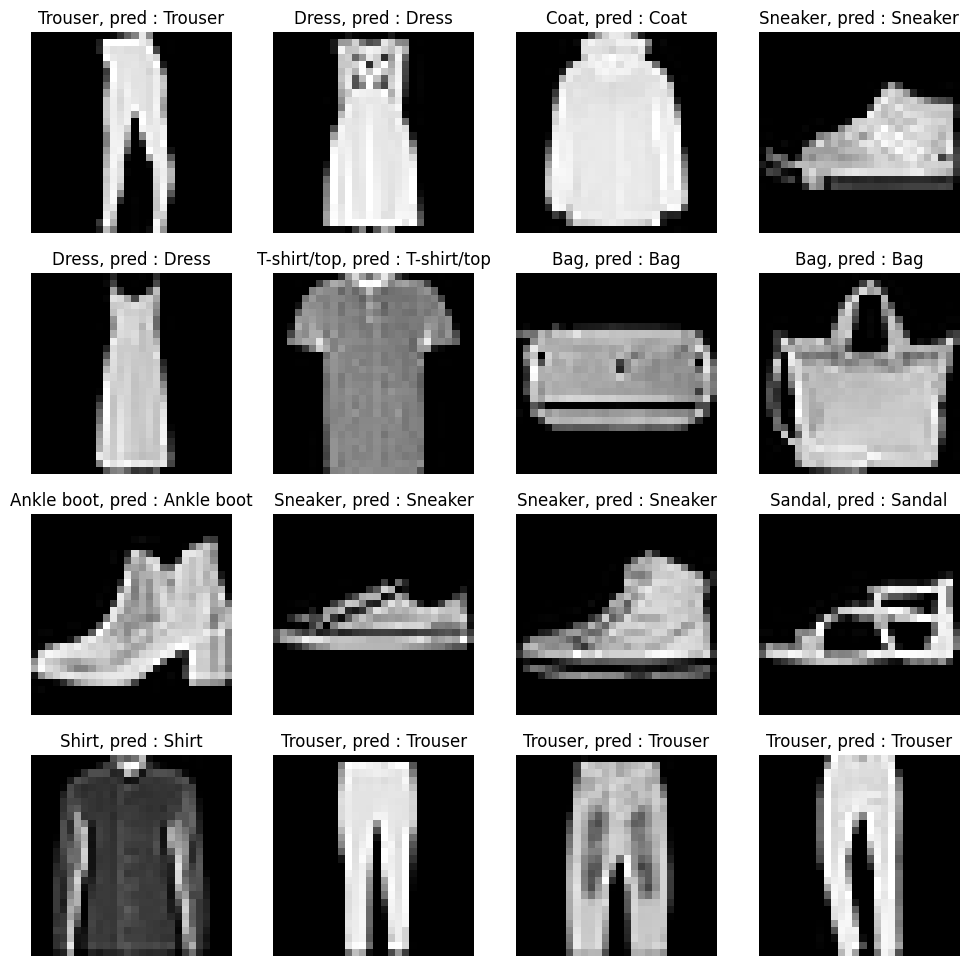

In [ ]:
visual_test_cnn(model1)